In [1]:
## Initialize ##
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import scipy as sp
import scipy.special as scsp
import random as rand
from scipy.optimize import fsolve
import os
from tqdm import tqdm
from class_carbon_gambling import *
from colorsarr import colorsarr #For the colormap
colarr = colorsarr()
carr = colarr.carr
cd = os.getcwd()

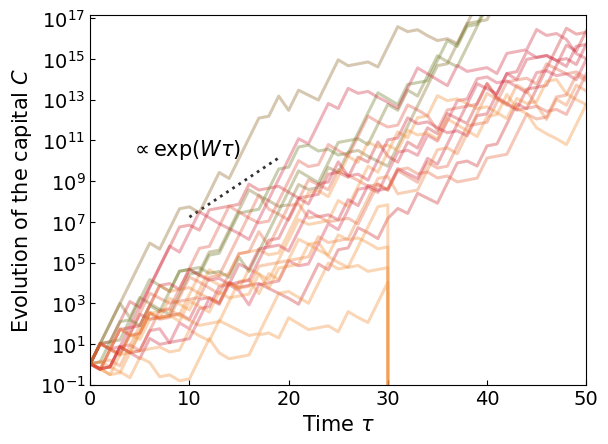

In [8]:
# Example of evolution for a given set of horses
pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
model = kelly_debt(5, 1.05, 1, 30, 1.2, 50, pini=pini, rini=rini, rhoini=np.exp(0.69), borroweachstep=True) #Stochastic model
model.plot_evol(int(2E1), scale = 'log') #Plot stochastic evolution

In [9]:
#Compute survival proba from simulations (discrete)#

tf = 40
rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
            np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] #List of interest rate values to test

pini=[0.03, 0.20, 0.39, 0.12, 0.26] #Initial probabilities
rini=[0.15, 0.39, 0.04, 0.21, 0.21] #Initial returns

borroweachstep = False #Choose strategy A with borroweachstep = False, and strategy B with borroweachstep = True
strat = 'A' if not borroweachstep else 'B' #Strategy A or B
L = 10. #Leverage
cd = os.getcwd()

for i, rho in enumerate(tqdm(rholist)):
    model = kelly_debt(5, L, 1, tf, rho, 50,  pini=pini, rini=rini, rhoini=rho, borroweachstep=borroweachstep) #Choose strategy A with borroweachstep = False, and strategy B with borroweachstep = True
    x = model.survprob(tf)
    np.save(cd + r'/data/xlist_disc'+strat+str(i)+str(L)+r'.npy', np.array(x))

100%|██████████| 12/12 [20:21<00:00, 101.81s/it]


In [10]:
#Compute survival proba from simulations (Gaussian approximation)#

tf = 40 #Final time to study survival
rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
            np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] #List of interest rate values to test

borroweachstep = True #Choose strategy A with borroweachstep = False, and strategy B with borroweachstep = True
strat = 'A' if not borroweachstep else 'B' #Strategy A or B
L = 1.05 #Leverage
cd = os.getcwd()

for i, rho in enumerate(tqdm(rholist)):
    model = kelly_debt(5, L, 1, tf, rho, 50,  pini=pini, rini=rini, rhoini=rho, W = np.log(2.003), sig=1.325, gaussian = True, borroweachstep=borroweachstep) #stochastic model with Gaussian approximation
    x = model.survprob(tf)
    np.save(cd + r'/data/xlist_gauss'+strat+str(i)+str(L)+r'.npy', np.array(x))

100%|██████████| 12/12 [05:14<00:00, 26.25s/it]


100%|██████████| 12/12 [00:00<00:00, 1172.00it/s]


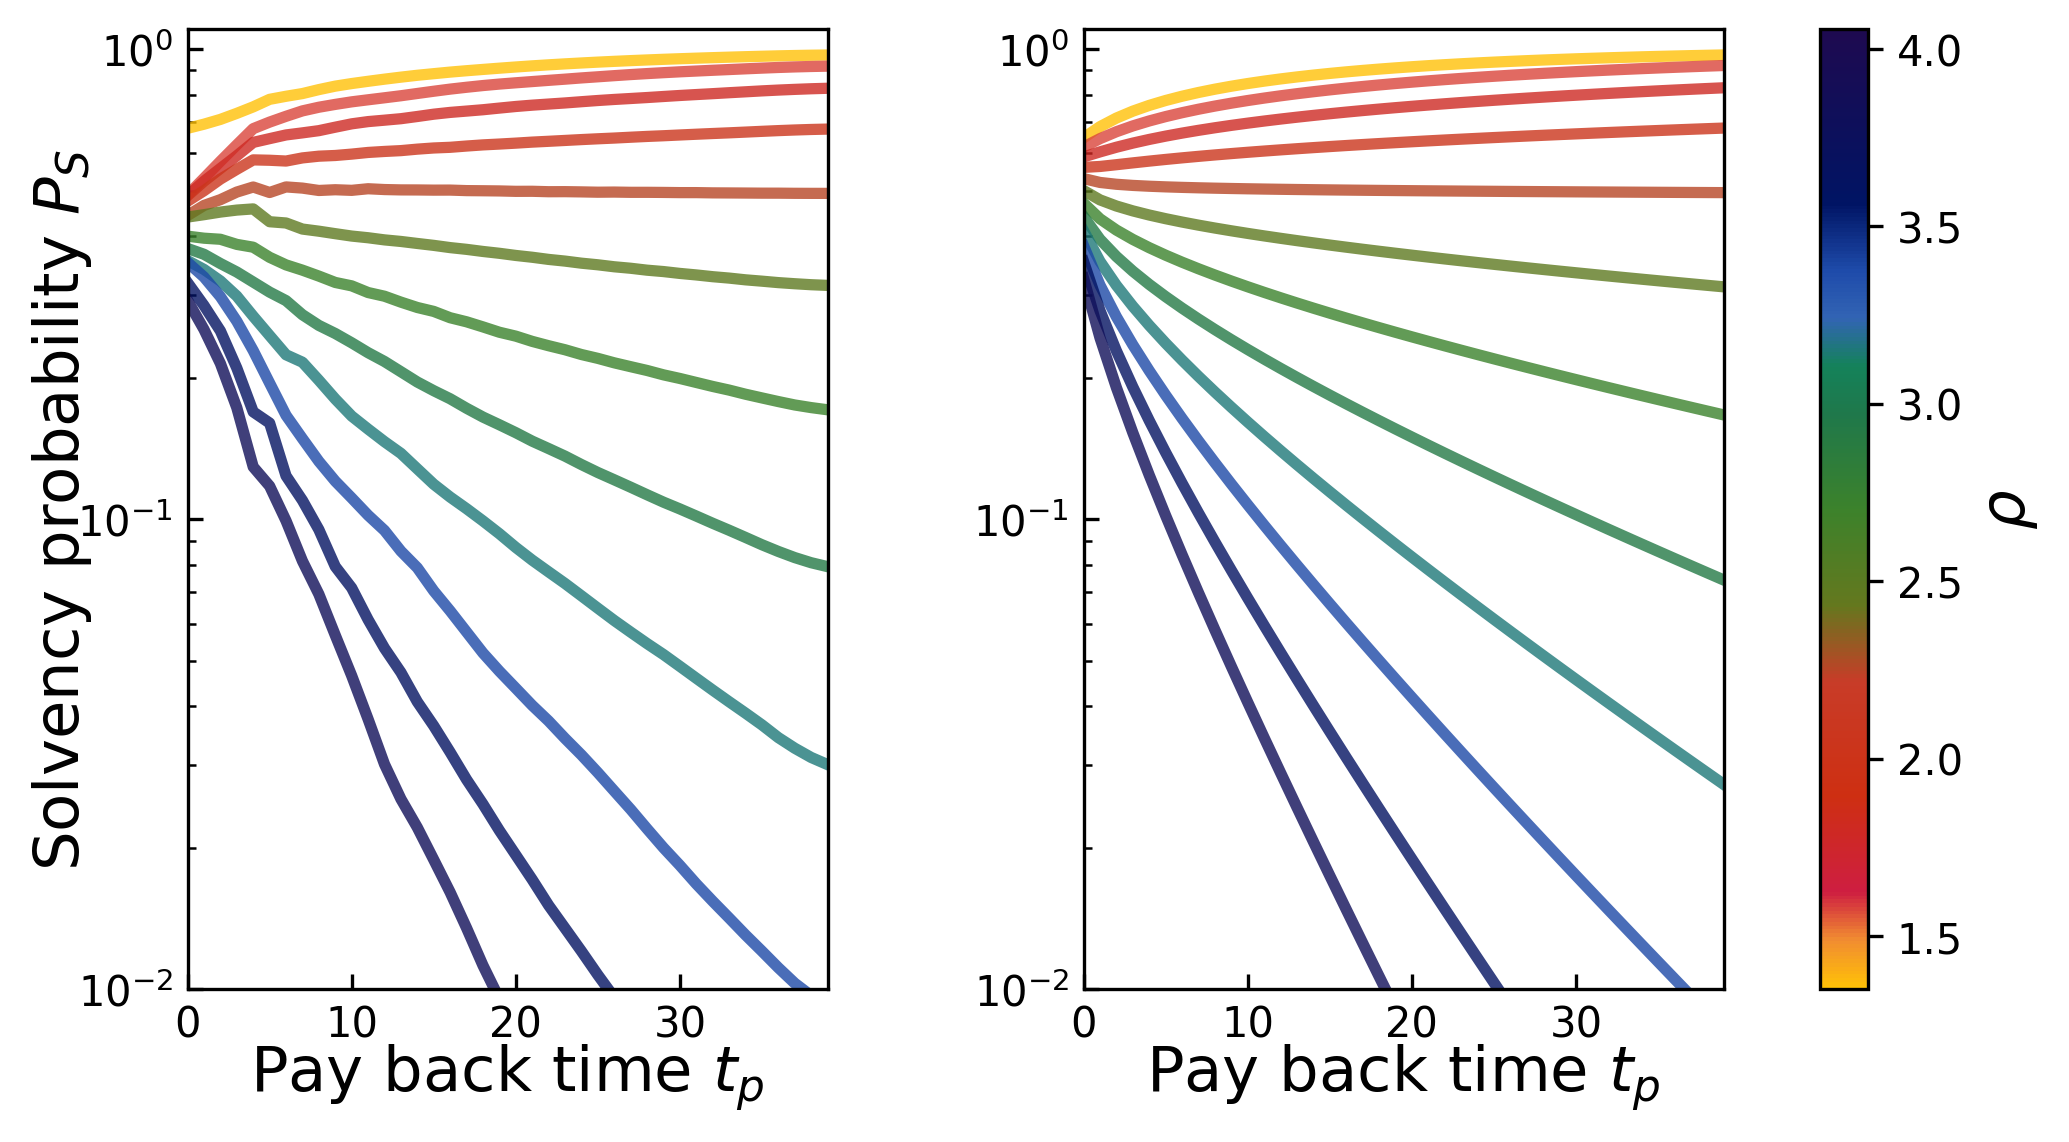

In [11]:
## Plot survival probability from simulations and theory ##
def smoothen(list, nm = 10): # Smoothen the list with a moving average
    reslist = []
    meanlist = [k-nm//2 for k in range(nm)]
    for j in range(len(list)):
        reslist.append((sum([list[min(max(0,j+k),len(list)-1)] for k in meanlist]))/nm)
    return reslist

pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
expW = np.exp(sum([pini[i]*np.log(pini[i]/rini[i]) for i in range(5)]))
rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
           np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] # List of interest rate values to test
L = 10. # Leverage
tf = 40 #Final time to study survival
cd = os.getcwd()

def survprob(tp, m, sig, L):
    z = (m*tp - np.log(1-1/L))/(np.sqrt(2*tp)*sig)
    return 0.5*(1+scsp.erf(z))

tplist = [i for i in range(40)]
mlist = [np.log(expW)-np.log(rho) for rho in rholist]
sigmalist = [np.sqrt(sum([pini[i]*(np.log(pini[i]/rini[i]/rholist[j]))**2 for i in range(5)]) - (sum([pini[i]*(np.log(pini[i]/rini[i]/rholist[j])) for i in range(5)]))**2) for j in range(len(rholist))]

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]),
         (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) # Create the color map
norm = mpl.colors.Normalize(vmin=rholist[0], vmax=rholist[-1], clip=False)

fig1 = plt.figure(figsize=(8, 4), dpi=300)
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.4,hspace=0.4)
ax1.set_xlabel(r'Pay back time $t_p$', labelpad=-1, fontsize=15)
ax1.set_ylabel(r'Solvency probability $P_S$', labelpad=-4, fontsize=15)
ax2.set_xlabel(r'Pay back time $t_p$', labelpad=-1, fontsize=15)

for i, rho in enumerate(tqdm(rholist)):
    xlist = np.load(cd + r'/data/xlist_discA'+str(i)+str(L)+r'.npy')
    xlist = np.array(smoothen(xlist, nm=7))
    ax1.plot(range(xlist.size), xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(rholist)), label=r'$\rho = {}$'.format(str(rho)[:5]))

for i, m in enumerate(tqdm(mlist)):
    xlist = np.array([survprob(tp+1, m, sigmalist[i], L) for tp in range(tf)])
    ax2.plot(range(xlist.size), xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(mlist)), label=r'$\rho = {}$'.format(str(rho)[:5]))

ax1.margins(x=0)
ax1.tick_params(direction='in', which='both') 
ax1.set_yscale('log')
ax1.set_ylim(1E-2, 1.1E0)

cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=[ax1, ax2], label=r'$\rho$')
cbar.set_label(r'$\rho$', fontsize=15)
ax2.margins(x=0)
ax2.tick_params(direction='in', which='both') 
ax2.set_yscale('log')
ax2.set_ylim(1E-2, 1.1E0)
fig1.savefig(cd + r'/results/survprob_stratA'+str(L)+'.pdf')

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 896.06it/s]


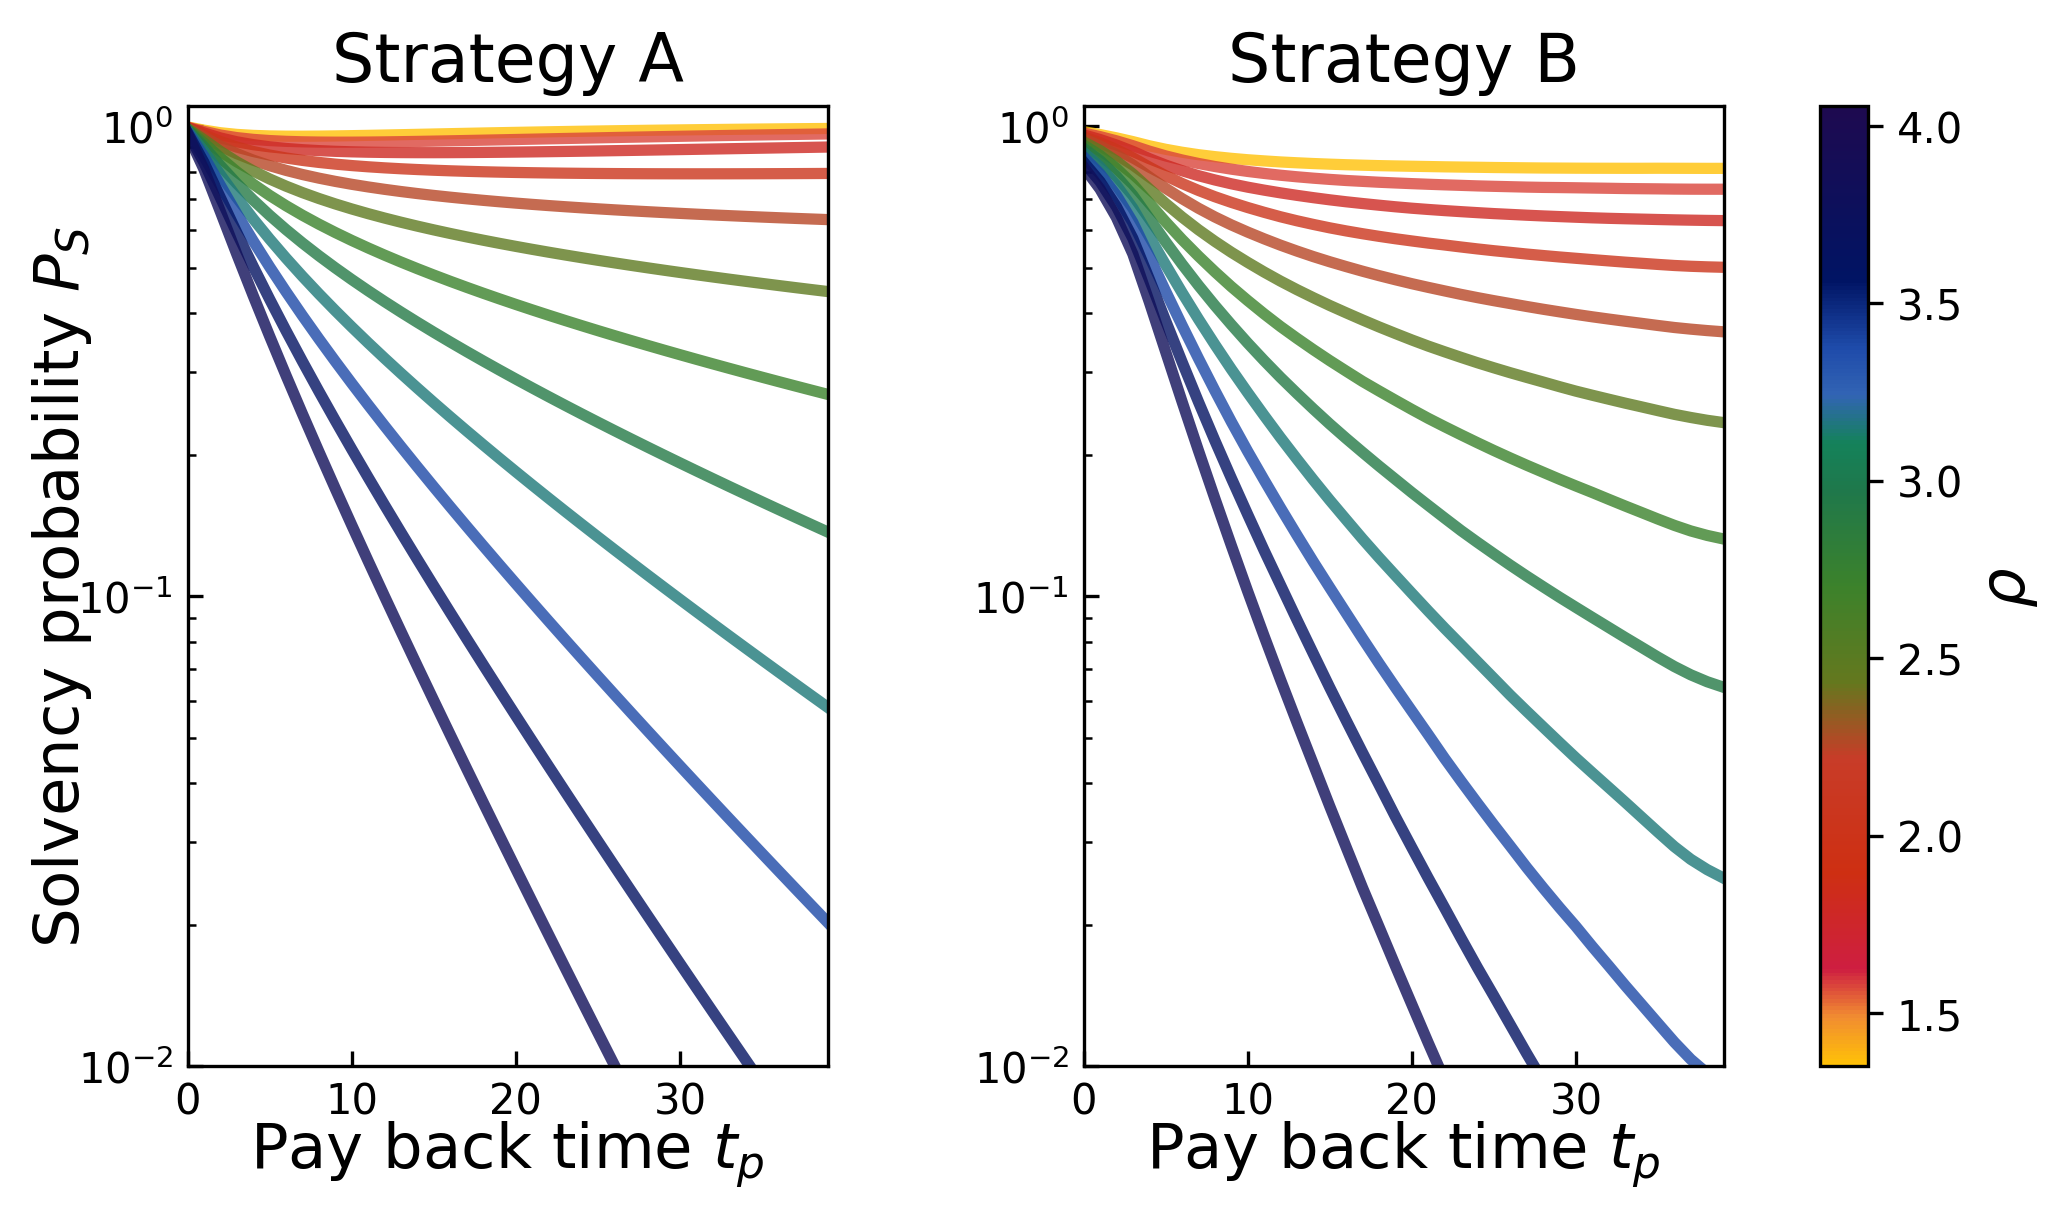

In [12]:
## Plot survival probability for strategy B from simulations, compare to strategy A##

def smoothen(list, nm = 10): # Smoothen the list with a moving average
    reslist = []
    meanlist = [k-nm//2 for k in range(nm)]
    for j in range(len(list)):
        reslist.append((sum([list[min(max(0,j+k),len(list)-1)] for k in meanlist]))/nm)
    return reslist

pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
expW = np.exp(sum([pini[i]*np.log(pini[i]/rini[i]) for i in range(5)])) # exp(W)
rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
           np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] # List of interest rate values to test
L = 1.05 # Leverage
cd = os.getcwd()

def survprob(tp, m, sig, L):
    z = (m*tp - np.log(1-1/L))/(np.sqrt(2*tp)*sig)
    return 0.5*(1+scsp.erf(z)) #Analytical value of the survival probability

mlist = [np.log(expW)-np.log(rho) for rho in rholist] # List of m values for each interest rate
sigmalist = [np.sqrt(sum([pini[i]*(np.log(pini[i]/rini[i]/rholist[j]))**2 for i in range(5)]) - (sum([pini[i]*(np.log(pini[i]/rini[i]/rholist[j])) for i in range(5)]))**2) for j in range(len(rholist))] # List of sigma values for each interest rate


fig1 = plt.figure(figsize=(8, 4), dpi=300)
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.4,hspace=0.4)
ax1.set_xlabel(r'Pay back time $t_p$', labelpad=-1, fontsize=15)
ax1.set_ylabel(r'Solvency probability $P_S$', labelpad=-4, fontsize=15)
ax2.set_xlabel(r'Pay back time $t_p$', labelpad=-1, fontsize=15)
ax1.set_title(r'Strategy A', fontsize=16)
ax2.set_title(r'Strategy B', fontsize=16)

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]),
         (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) # Create the color map
norm = mpl.colors.Normalize(vmin=rholist[0], vmax=rholist[-1], clip=False)

for i, m in enumerate(tqdm(mlist)):
    xlist = np.array([survprob(tp+1, m, sigmalist[i], L) for tp in tplist])
    ax1.plot(range(xlist.size), xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(mlist)), label=r'$\rho = {}$'.format(str(rho)[:5]))

for i, rho in enumerate(tqdm(rholist)):
    xlist = np.load(cd + r'/data/xlist_gaussB'+str(i)+str(L)+r'.npy')
    xlist = np.array(smoothen(xlist, nm=7))
    ax2.plot(range(xlist.size), xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(rholist)), label=r'$\rho = {}$'.format(str(rho)[:5]))

ax1.margins(x=0)
ax1.tick_params(direction='in', which='both') 
ax1.set_yscale('log')
ax1.set_ylim(1E-2, 1.1E0)

cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=[ax1, ax2], label=r'$\rho$')
cbar.set_label(r'$\rho$', fontsize=15)
ax2.margins(x=0)
ax2.tick_params(direction='in', which='both') 
ax2.set_yscale('log')
ax2.set_ylim(1E-2, 1.1E0)
fig1.savefig(cd + r'/results/survprob_kelly_stratB'+str(L)+'.pdf')

4.3015402930402935 0.6946606007908955 2.25


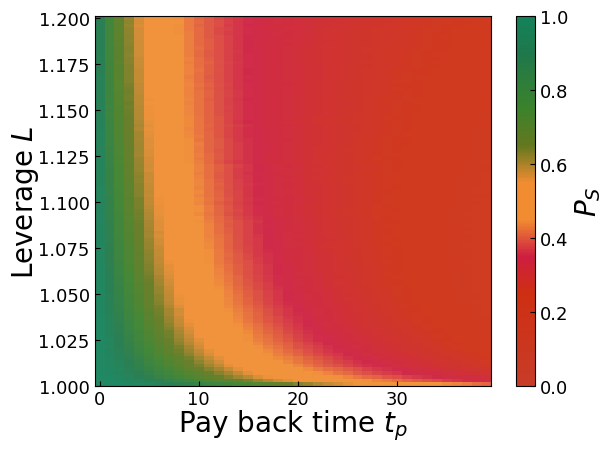

In [13]:
## Infuence of Leverage on survival probability for strategy B (colormap) #
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

Larr = np.linspace((1.001), (1.2), 100)

## Gaussian case ##
import scipy.special as scsp
pini=[0.03, 0.20, 0.39, 0.12, 0.26] #Initial probabilities of horses
rini=[0.15, 0.39, 0.04, 0.21, 0.21] #Initial returns of horses
expW = np.exp(sum([pini[i]*np.log(pini[i]/rini[i]) for i in range(5)])) # exp(W)
tf = 40 #Final time to study survival
rho = 2.25 #Interest rate
print(sum([pini[i]*pini[i]/rini[i] for i in range(5)]), np.log(expW), rho)

sig = np.sqrt(sum([pini[i]*(np.log(pini[i]/rini[i]/rho))**2 for i in range(5)]) - (sum([pini[i]*(np.log(pini[i]/rini[i]/rho)) for i in range(5)]))**2) # Standard deviation of the growth rate
cd = os.getcwd()

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
ax1.set_xlabel(r'Pay back time $t_p$', labelpad=-1, fontsize=20)
ax1.set_ylabel(r'Leverage $L$', labelpad=-2, fontsize=20)
#ax1.set_title(r'$\rho={}$'.format(rho), fontsize=16)

clist = carr[:13].copy()
#clist.reverse()
clist = [(0, clist[4]), (0.25, clist[3]), (0.35, clist[2]), (0.45, clist[1]), (0.55, clist[1]),
         (0.65, clist[5]), (0.75, clist[6]), (0.9, clist[7]), (1., clist[8])] 
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) # Create the color map
norm = mpl.colors.Normalize(vmin=0., vmax=1., clip=False)

PSlist = []
compute = False #False to plot directly without having to compute everything again
if compute :
    for i, L in enumerate(tqdm(Larr)):
        model = kelly_debt(5, L, 1., tf, rho, 50, pini=pini, rini=rini, rhoini=rho, gaussian=True, W = np.log(expW), sig=sig, borroweachstep=True) # Stochastic model with different interest rate
        PSlist.append(model.survprob(tf)) #Appends survival for all times at fixed leverage
    np.save(cd + r'/data/PSlistfast_stratB'+str(rho)+r'.npy', np.array(PSlist)) 
PSlist = np.load(cd + r'/data/PSlistfast_stratB'+str(rho)+r'.npy')
X, Y = np.meshgrid(range(PSlist[0].size), Larr)
ax1.pcolormesh(X, Y, PSlist, cmap=cmapphase, norm=norm, alpha=0.95, lw=0.5)

cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$\ln(L)$')
cbar.set_label(r'$P_S$', fontsize=20)
cbar.ax.tick_params(direction='in', which='both', labelsize=13)
ax1.tick_params(direction='in', which='both', labelsize=13)
ax1.margins(x=0)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + r'/results/survprob_gaussian_difL'+str(rho)+'.pdf')

W :  0.6946606007908955 rho :  1.5


100%|██████████| 5/5 [00:00<00:00, 389.22it/s]
/var/folders/48/ttgfc92s2p51wx_3w13qnqd00000gn/T/ipykernel_2261/2315848686.py:78: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.tight_layout()


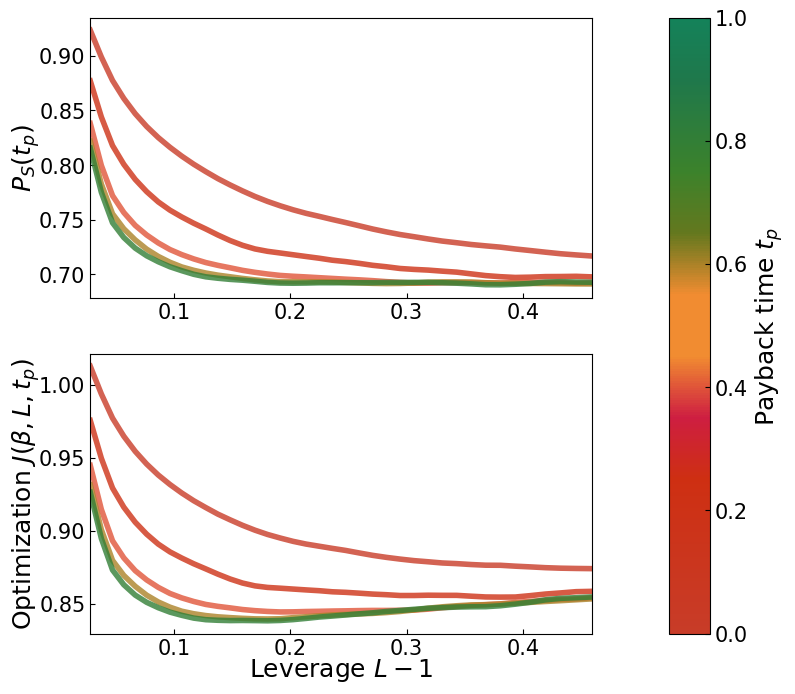

In [2]:
## Infuence of Leverage on survival probability and long term growth rate for strategy B (2D plot) ##
clist = carr[:13].copy()
#clist.reverse()
clist = [(0, clist[4]), (0.25, clist[3]), (0.35, clist[2]), (0.45, clist[1]), (0.55, clist[1]),
         (0.65, clist[5]), (0.75, clist[6]), (0.9, clist[7]), (1., clist[8])] 
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) # Create the color map

Larr = np.logspace(np.log10(1.0000000001), np.log10(1.5), 45)
tfarr = [5, 10, 20, 30, 39]

def smoothen(list, nm = 10): # Smoothen the list with a moving average
    reslist = []
    meanlist = [k-nm//2 for k in range(nm)]
    for j in range(len(list)):
        reslist.append((sum([list[min(max(0,j+k),len(list)-1)] for k in meanlist]))/nm)
    return reslist

def grate(L, tp, gamma, std):
    return np.log(gamma+L-1.)

## Gaussian case ##
import scipy.special as scsp
pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
expW = np.exp(sum([pini[i]*np.log(pini[i]/rini[i]) for i in range(5)])) # exp(W)
gamma = sum([pini[i]*pini[i]/rini[i] for i in range(5)])
tf = 40 # Final time to study survival
rho = 1.5 # Interest rate
beta = 0.2

sig = np.sqrt(sum([pini[i]*(np.log(pini[i]/rini[i]/rho))**2 for i in range(5)]) - (sum([pini[i]*(np.log(pini[i]/rini[i]/rho)) for i in range(5)]))**2) #standard deviation of the implicit growth rate
print('W : ', np.log(expW), 'rho : ', rho)

cd = os.getcwd()
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
cbar_ax = plt.subplot2grid((1, 2), (0, 1))
cbar_ax.set_box_aspect(15)
ax1.set_ylabel(r'$P_S(t_p)$', labelpad=-2, fontsize=18)
ax2.set_xlabel(r'Leverage $L - 1$', labelpad=-1, fontsize=18)
ax2.set_ylabel(r'Optimization $J(\beta, L, t_p)$', labelpad=-2, fontsize=18)

compute = False #False to plot directly without having to compute everything again
if compute :
    xarray = []
    garray = np.zeros((Larr.size, len(tfarr)))
    for i, L in enumerate(tqdm(Larr)):
        model = kelly_debt(5, L, 1., tf, rho, 50, pini=pini, rini=rini, rhoini=rho, gaussian=True, W = np.log(expW), sig=sig, borroweachstep=True) # Stochastic model with different interest rate
        xlist = model.survprob(tf, repet=5E4)
        xarray.append(xlist) # Appends survival for all times at fixed leverage
        for j, tp in enumerate(tqdm(tfarr)):
            garray[i,j] = grate(L, tp, gamma, sig)
    np.save(cd + r'/data/glistvsL_gaussB'+str(rho)+r'.npy', np.array(garray))
    np.save(cd + r'/data/PSlistvsL_gaussB'+str(rho)+r'.npy', np.array(xarray))
xarray = np.load(cd + r'/data/PSlistvsL_gaussB'+str(rho)+r'.npy')
garray = np.load(cd + r'/data/glistvsL_gaussB'+str(rho)+r'.npy')
xarray = np.array(xarray)
garray = np.array(garray)
for i, tf in enumerate(tqdm(tfarr)):
    xlist = np.array(smoothen(smoothen(xarray[:, tf], nm=4), nm=4))
    glist = np.array(smoothen(garray[:,i], nm=10))
    ax1.plot(Larr[3:-3]-1., xlist[3:-3], alpha = 0.8, c=cmapphase(i/len(tfarr)), label=r'$t_p = {}$'.format(str(tf)[:5]), lw=4.)
    ax2.plot(Larr[3:-3]-1., beta*glist[3:-3]+(1.-beta)*xlist[3:-3], alpha = 0.8, c=cmapphase(i/len(tfarr)), label=r'$t_p = {}$'.format(str(tf)[:5]), lw=4.)

norm = mpl.colors.Normalize(vmin=min(tfarr), vmax=max(tfarr), clip=False)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, orientation='vertical', cmap=cmapphase)
cbar.set_label(r'Payback time $t_p$', fontsize=18)
ax1.margins(x=0)
ax2.margins(x=0)
#ax1.set_xscale('log')
#ax1.set_yscale('log')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax1.tick_params(direction='in', which='both', labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=15)
cbar_ax.tick_params(direction='in', which='both', labelsize=15)
fig.tight_layout()
fig.savefig(cd + r'/results/PS_difLB'+str(rho)+'.pdf')